In [ ]:
# pylint: disable=E0401

import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from lifelines import KaplanMeierFitter
from scipy import stats

warnings.filterwarnings("ignore")

df = pd.read_csv("/Users/hee/Desktop/HR/HR-analysis/data/HR.csv")

df["Date of Birth"] = pd.to_datetime(df["Date of Birth"])
df["Date of Hire"] = pd.to_datetime(df["Date of Hire"])
df["Date of Termination"] = pd.to_datetime(df["Date of Termination"])

df["Age"] = pd.to_datetime("2015-01-01").year - df["Date of Birth"].dt.year
df["Age"] = df["Age"].apply(lambda x: x + 100 if x < 0 else x)

df["Tenure"] = ((df["Date of Termination"].fillna(pd.to_datetime("today"))) - df["Date of Hire"]).dt.days / 365
df["Attrition"] = df["Employment Status"].apply(lambda x: 1 if x != "Active" else 0)

In [2]:
df.head(20)

,Employee Number,Employee Name,Date of Birth,Sex,Citizenship,Race,State,Zip,Marital Status,Department,...,Performance Score,Pay Rate,Employee Source,Employment Status,Date of Hire,Date of Termination,Reason for Termination,Age,Tenure,Attrition
0,1103024456,"Brown, Mia",1987-11-24,Female,US Citizen,African American,MA,1450,Married,Admin Offices,...,Fully Meets,28.50,Diversity Job Fair,Active,2012-10-27,NaT,NaN,28,12.646575,0
1,1106026572,"LaRotonda, William",1984-04-26,Male,US Citizen,African American,MA,1460,Divorced,Admin Offices,...,Fully Meets,23.00,Website Banner Ads,Active,2018-01-06,NaT,NaN,31,7.449315,0
2,1302053333,"Steans, Tyrone",1986-09-01,Male,US Citizen,White,MA,2703,Single,Admin Offices,...,Fully Meets,29.00,Internet Search,Active,2018-09-29,NaT,NaN,29,6.720548,0
3,1211050782,"Howard, Estelle",1985-09-16,Female,US Citizen,White,MA,2170,Married,Admin Offices,...,NaN,21.50,Pay Per Click - Google,Active,2019-02-16,NaT,NaN,30,6.336986,0
4,1307059817,"Singh, Nan",1988-05-19,Female,US Citizen,White,MA,2330,Single,Admin Offices,...,NaN,16.56,Website Banner Ads,Active,2019-05-01,NaT,NaN,27,6.134247,0
5,711007713,"Smith, Leigh Ann",1987-06-14,Female,US Citizen,Asian,MA,1844,Married,Admin Offices,...,Fully Meets,20.50,Diversity Job Fair,Voluntarily Terminated,2015-09-26,2017-09-25,Another Position / Career Change,28,2.000000,1
6,1102024115,"LeBlanc, Brandon R",1984-06-10,Male,US Citizen,White,MA,1460,Married,Admin Offices,...,Fully Meets,55.00,Monster.com,Active,2020-01-05,NaT,NaN,31,5.452055,0
7,1206043417,"Quinn, Sean",1984-11-06,Male,Eligible NonCitizen,African American,MA,2045,Married,Admin Offices,...,Fully Meets,55.00,Diversity Job Fair,Voluntarily Terminated,2015-02-21,2019-08-15,Another Position / Career Change,31,4.482192,1
8,1307060188,"Boutwell, Bonalyn",1987-04-04,Female,US Citizen,Asian,MA,2468,Married,Admin Offices,...,Fully Meets,34.95,Diversity Job Fair,Active,2019-02-16,NaT,NaN,28,6.336986,0
9,1201031308,"Foster-Baker, Amy",1979-04-16,Female,US Citizen,White,MA,2050,Married,Admin Offices,...,Fully Meets,34.95,Other,Active,2013-01-05,NaT,NaN,36,12.454795,0


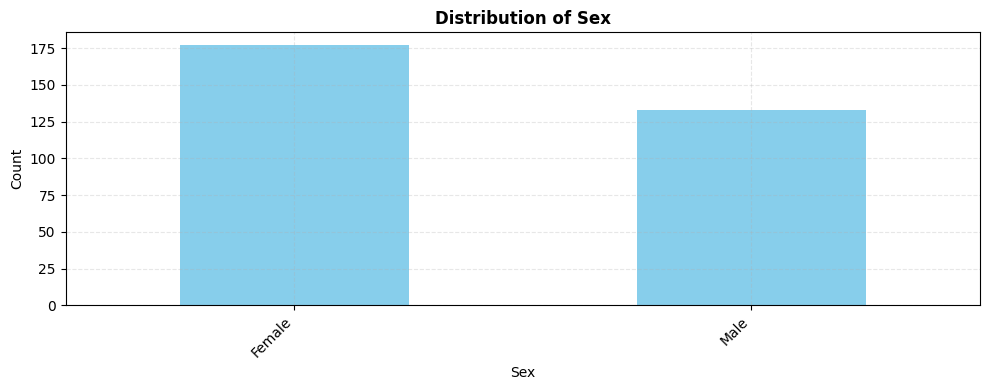

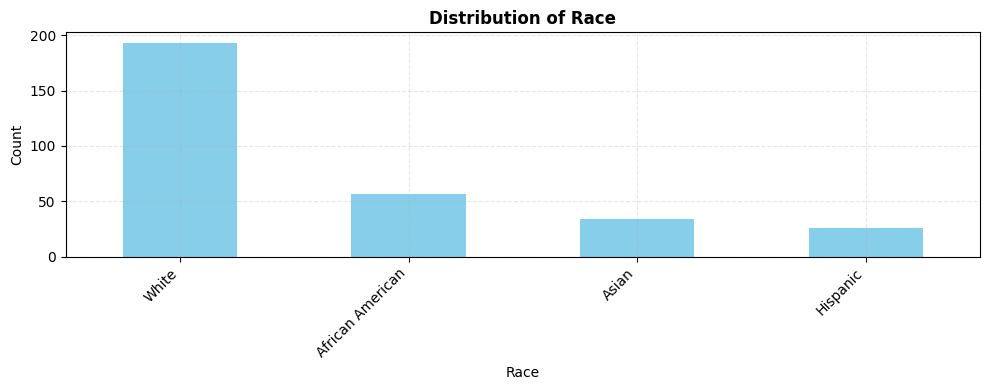

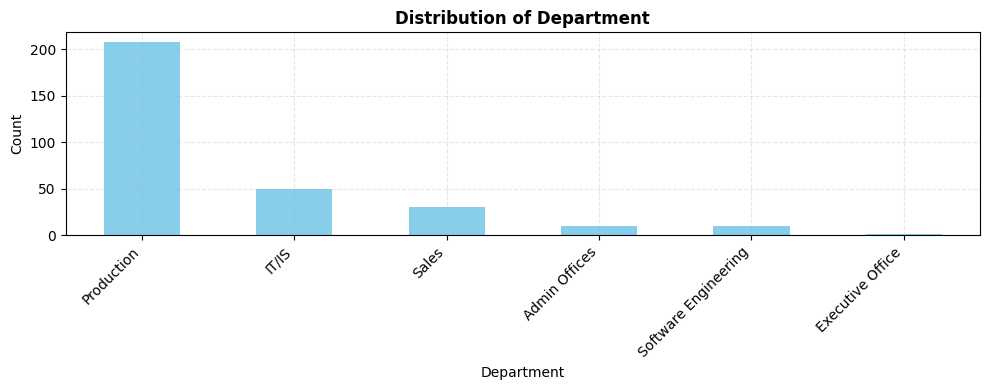

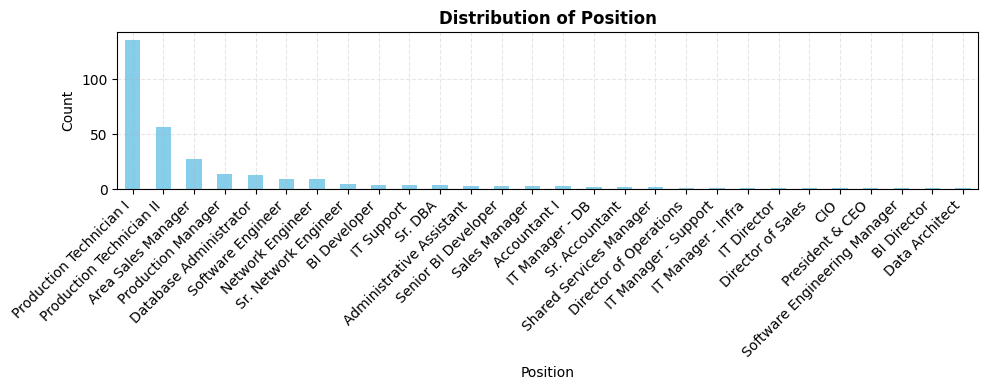

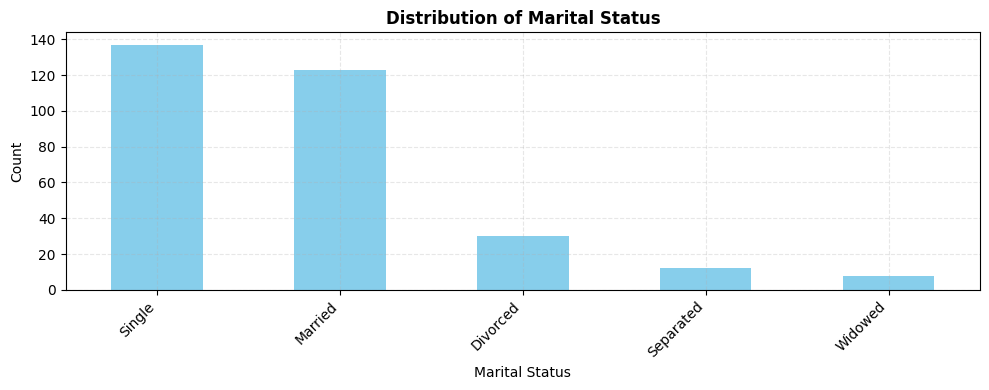

In [3]:
categorical_vars = ["Sex", "Race", "Department", "Position", "Marital Status"]

for col in categorical_vars:
    plt.figure(figsize=(10, 4))
    df[col].value_counts().plot(kind="bar", color="skyblue")
    plt.title(f"Distribution of {col}", fontweight="bold")
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.grid(True, alpha=0.3, linestyle="--")
    plt.show()

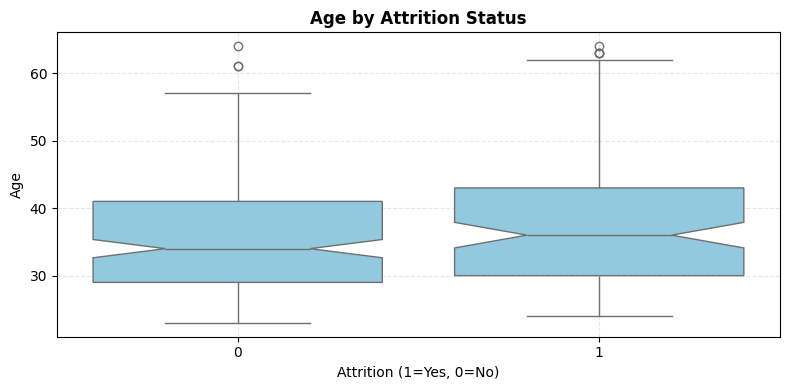

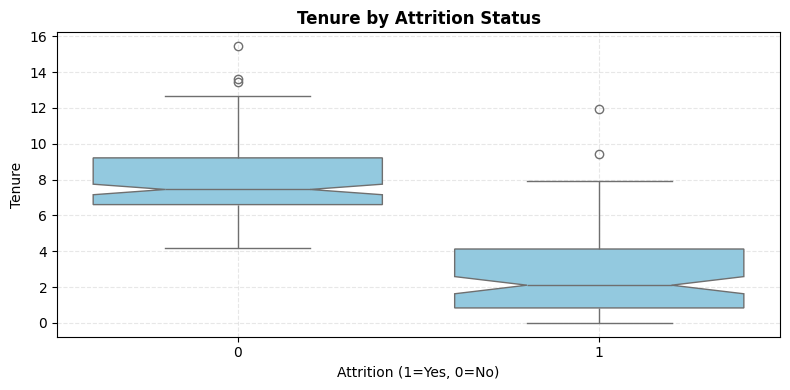

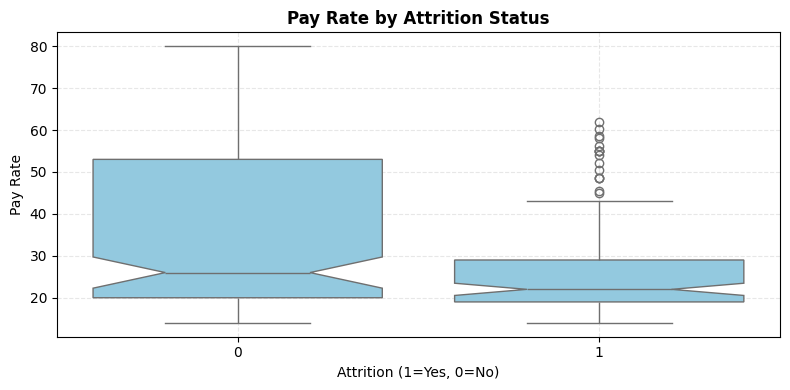

In [4]:
for feature in ["Age", "Tenure", "Pay Rate"]:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x="Attrition", y=feature, data=df, color="skyblue", notch=True)
    plt.title(f"{feature} by Attrition Status", fontweight="bold")
    plt.xlabel("Attrition (1=Yes, 0=No)")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.grid(True, alpha=0.3, linestyle="--")
    plt.show()

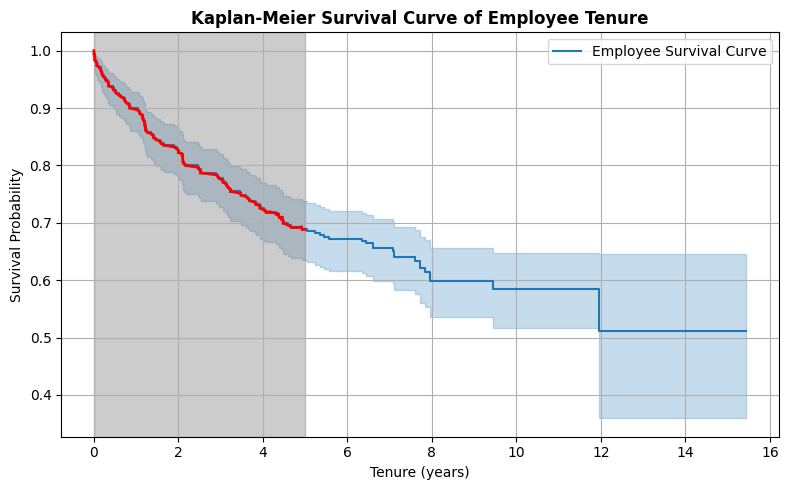

In [5]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 5))
kmf.fit(df["Tenure"], event_observed=df["Attrition"], label="Employee Survival Curve")
ax = kmf.plot(ci_show=True)

# 1. 강조 구간 배경 표시: x=0~4 구간
plt.axvspan(0, 5, color="gray", alpha=0.4, label="Early Tenure Zone")

# 2. 빨간 기울기선 덧그리기 (0 <= x <= 4)
surv_df = kmf.survival_function_.reset_index()
surv_df.columns = ["Tenure", "Survival"]

for i in range(1, len(surv_df)):
    x1, x2 = surv_df.loc[i - 1, "Tenure"], surv_df.loc[i, "Tenure"]
    y1, y2 = surv_df.loc[i - 1, "Survival"], surv_df.loc[i, "Survival"]

    if x2 <= 5:  # 강조 범위 내인 경우만 빨간선 추가
        plt.plot([x1, x2], [y1, y2], color="red", linewidth=2)

plt.title("Kaplan-Meier Survival Curve of Employee Tenure", fontweight="bold")
plt.xlabel("Tenure (years)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# pylint: disable=W0104

# ANOVA
anova_results = {}

for var in ["Position", "Department", "Sex", "Race"]:
    groups = [group["Performance Rank"].dropna() for _, group in df.groupby(var)]
    if len(groups) > 1:
        f_val, p_val = stats.f_oneway(*groups)
        anova_results[var] = {"F-value": f_val, "p-value": p_val}

anova_df = pd.DataFrame(anova_results).T
anova_df = anova_df.sort_values(by="p-value")

anova_df

,F-value,p-value
Sex,1.191110,0.275959
Position,1.112546,0.323749
Department,0.584290,0.712039
Race,0.158264,0.924305


In [7]:
# pylint: disable=W0104

source_summary = (
    df.groupby("Employee Source")
    .agg(
        avg_perf_rank=("Performance Rank", "mean"),
        avg_pay=("Pay Rate", "mean"),
        attrition_rate=("Attrition", "mean"),
        count=("Employee Name", "count"),
    )
    .sort_values(by="count", ascending=False)
)

source_summary

,avg_perf_rank,avg_pay,attrition_rate,count
Employee Source,,,,
Employee Referral,2.774194,36.250000,0.161290,31
Diversity Job Fair,2.758621,28.728276,0.655172,29
Search Engine - Google Bing Yahoo,2.800000,24.978400,0.640000,25
Monster.com,2.708333,31.588333,0.458333,24
Pay Per Click - Google,2.714286,40.045238,0.142857,21
Professional Society,2.750000,31.212500,0.200000,20
Newspager/Magazine,2.333333,23.875000,0.277778,18
MBTA ads,3.176471,24.514706,0.294118,17
Billboard,2.812500,30.078125,0.312500,16


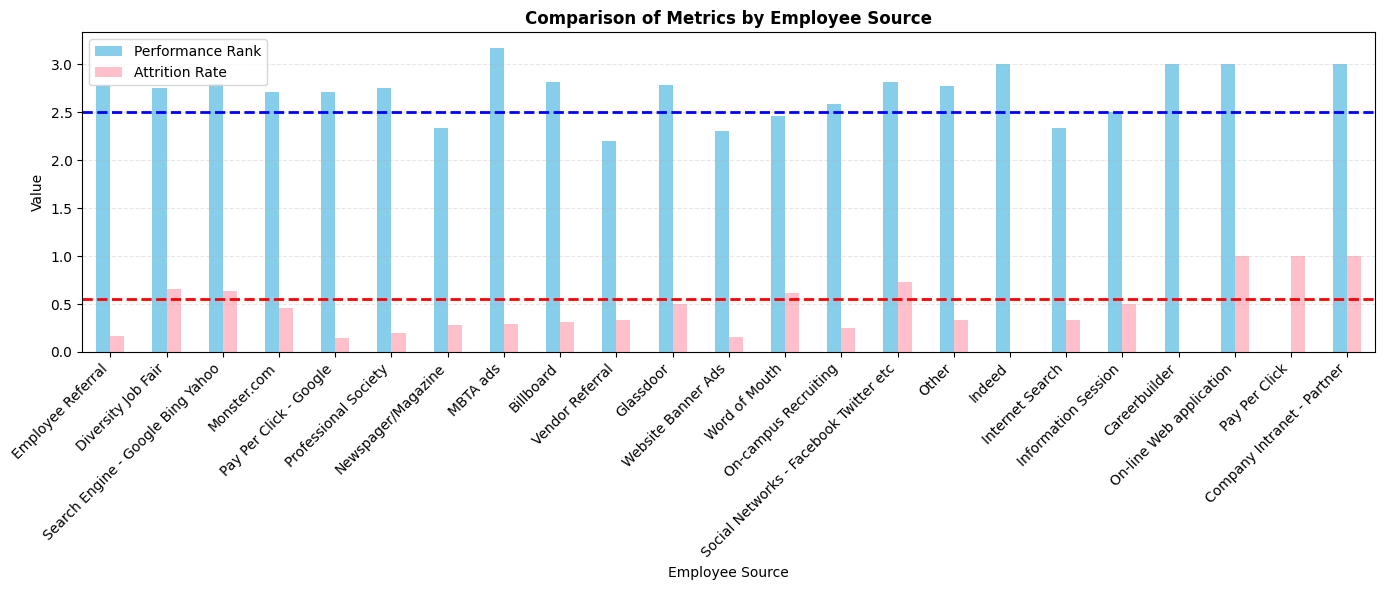

In [8]:
# 필요한 컬럼만 추출
cols_to_plot = ["avg_perf_rank", "attrition_rate"]


# 데이터 준비: 인덱스를 컬럼으로 옮기고 필요한 열만 추출
plot_data = source_summary[cols_to_plot].copy()
plot_data.index.name = "Employee Source"
plot_data = plot_data.reset_index()


# 시각화
plot_data.set_index("Employee Source")[cols_to_plot].plot(kind="bar", figsize=(14, 6), color=["skyblue", "pink"])
plt.title("Comparison of Metrics by Employee Source", fontweight="bold")
plt.ylabel("Value")
plt.xlabel("Employee Source")
plt.xticks(rotation=45, ha="right")
plt.legend(title="", labels=["Performance Rank", "Attrition Rate"])
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()

# 기준선 추가
plt.axhline(2.5, color="blue", linewidth=2, linestyle="--")
plt.axhline(0.55, color="red", linewidth=2, linestyle="--")

plt.show()